## Image processing is a basic first step

Image processing includes actions such as filtering, counting pixels with certain values, identifying basic differences between images and of course changing the way the image looks (ostensibly to highlight features of interest). This set of tasks is specific to the workflow of a researcher, an artist may never do any of these things. We do them because we have images and need data. It may be that we are interested in the data we can extract directly, or that we want to use image processing to reduce the images to basic features so that machine learning or other data analysis algorithms can act on them efficiently.

https://scikit-image.org/docs/dev/auto_examples/index.html

https://scikit-learn.org/stable/auto_examples/index.html

## Filtering an image

Probably the first thing you think of when someone mentions image processing is filtering. There are many kinds of filters that can be applied some are designed to reconstruct images, others are designed to stylize them or highlight certain features. See skimage's [restoration module](https://scikit-image.org/docs/dev/api/skimage.restoration.html?highlight=restoration#module-skimage.restoration) for many options for reconstructing images. Alternatively see the [filters module](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters) for more general filters. Using a basic filter for restoration is demonstrated below in "image deconvolution".

One of the key challenges in applying filters to images specficially is that filters are designed for arrays where each dimension corresponds to the same kind of variable (X,Y,Z are all space variables) so it isn't clear how to apply it to an RGB array. The laziest thing to do is just convert RGB (Red Green Blue) to HSV (Hue Saturation Value) and run the filter on the dimension corresponding to "Value" then convert back. This is demonstrated below, but be aware that applying the same filter to all frequency channels may not be appropriate, especially if you are analyzing an RGB simplification of a hyperspectral image. 


[Richardson-Lucy image restoration with known PSF](https://scikit-image.org/docs/dev/auto_examples/filters/plot_deconvolution.html#sphx-glr-auto-examples-filters-plot-deconvolution-py) **Copied below and executed**

[Adapting stylization filters to color images](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_adapt_rgb.html#sphx-glr-auto-examples-color-exposure-plot-adapt-rgb-py) **Copied below and executed**


### Image Deconvolution

In this example, we deconvolve an image using Richardson-Lucy
deconvolution algorithm ([1]_, [2]_).

The algorithm is based on a PSF (Point Spread Function),
where PSF is described as the impulse response of the
optical system. The blurred image is sharpened through a number of
iterations, which needs to be hand-tuned. If you don't have the PSF already or the specialized software to estimate it, learn about how to get a rough estimate in this [stack overflow post](https://stackoverflow.com/questions/48819161/finding-for-convolution-kernel-if-many-0s-for-fft/48821963#48821963). Normally, you do not need to estimate it yourself unless you have imaging equipment built in house. 

.. [1] William Hadley Richardson, "Bayesian-Based Iterative
       Method of Image Restoration",
       J. Opt. Soc. Am. A 27, 1593-1607 (1972), :DOI:`10.1364/JOSA.62.000055`

.. [2] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution



In [0]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

astro = color.rgb2gray(data.astronaut())

# Blur Image with Arbitrary Point Spread Function
psf = np.ones((5, 5)) / 25
astro_blur = conv2(astro.copy(), psf, 'same')
# Add Noise to Image
astro_noisy = astro_blur.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro_blur.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


### Adapting gray-scale filters to RGB images


There are many filters that are designed to work with gray-scale images but not
with color images. To simplify the process of creating functions that can adapt
to RGB images, scikit-image provides the ``adapt_rgb`` decorator.

To actually use the ``adapt_rgb`` decorator, you have to decide how you want to
adapt the RGB image for use with the gray-scale filter. There are two
pre-defined handlers:

``each_channel``
    Pass each of the RGB channels to the filter one-by-one, and stitch the
    results back into an RGB image.
``hsv_value``
    Convert the RGB image to HSV and pass the value channel to the filter.
    The filtered result is inserted back into the HSV image and converted
    back to RGB.

Below, we demonstrate the use of ``adapt_rgb`` on a couple of gray-scale
filters:



In [0]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

We can use these functions as we would normally use them, but now they work
with both gray-scale and color images. Let's plot the results with a color
image:



In [0]:
from skimage import data
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

image = data.astronaut()

fig, (ax_each, ax_hsv) = plt.subplots(ncols=2, figsize=(14, 7))

# We use 1 - sobel_each(image) but this won't work if image is not normalized
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Sobel filter computed\n on individual RGB channels")

# We use 1 - sobel_hsv(image) but this won't work if image is not normalized
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Sobel filter computed\n on (V)alue converted image (HSV)")

Notice that the result for the value-filtered image preserves the color of
the original image, but channel filtered image combines in a more
surprising way. In other common cases, smoothing for example, the channel
filtered image will produce a better result than the value-filtered image.

You can also create your own handler functions for ``adapt_rgb``. To do so,
just create a function with the following signature::

    def handler(image_filter, image, *args, **kwargs):
        # Manipulate RGB image here...
        image = image_filter(image, *args, **kwargs)
        # Manipulate filtered image here...
        return image

Note that ``adapt_rgb`` handlers are written for filters where the image is
the first argument.

As a very simple example, we can just convert any RGB image to grayscale
and then return the filtered result:



In [0]:
from skimage.color import rgb2gray


def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

It's important to create a signature that uses ``*args`` and ``**kwargs``
to pass arguments along to the filter so that the decorated function is
allowed to have any number of positional and keyword arguments.

Finally, we can use this handler with ``adapt_rgb`` just as before:



In [0]:
@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

# We use 1 - sobel_gray(image) but this won't work if image is not normalized
ax.imshow(rescale_intensity(1 - sobel_gray(image)), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Sobel filter computed\n on the converted grayscale image")

plt.show()

<div class="alert alert-info"><h4>Note</h4><p>A very simple check of the array shape is used for detecting RGB
    images, so ``adapt_rgb`` is not recommended for functions that support
    3D volumes or color images in non-RGB spaces.</p></div>



## Geometrical manipulations and measurements

Another very basic operation you may be looking to perform in the course of your research is to simple warp an image, or to measure warp between two images or otherwise similar objects.

[Scaling rotation shifting and shearing of a whole image](https://scikit-image.org/docs/dev/auto_examples/applications/plot_geometric.html#sphx-glr-auto-examples-applications-plot-geometric-py)  **Copied below and executed**

[Uneven warping of images](https://scikit-image.org/docs/dev/auto_examples/transform/plot_piecewise_affine.html#sphx-glr-auto-examples-transform-plot-piecewise-affine-py)

[Measuring the shift between two images](https://scikit-image.org/docs/dev/auto_examples/transform/plot_masked_register_translation.html#sphx-glr-auto-examples-transform-plot-masked-register-translation-py)

[Locating items in an image based on item templates](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py)

[Locating items based on color differences](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py)


### Using geometric transformations


In this example, we will see how to use geometric transformations in the context
of image processing.



In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf

###Basics

Several different geometric transformation types are supported: similarity,
affine, projective and polynomial.

Geometric transformations can either be created using the explicit
parameters (e.g. scale, shear, rotation and translation) or the
transformation matrix:

First we create a transformation using explicit parameters:



In [0]:
tform = tf.SimilarityTransform(scale=1, rotation=math.pi/2,
                               translation=(0, 1))
print(tform.params)

Alternatively you can define a transformation by the transformation matrix
itself:



In [0]:
matrix = tform.params.copy()
matrix[1, 2] = 2
tform2 = tf.SimilarityTransform(matrix)

These transformation objects can then be used to apply forward and inverse
coordinate transformations between the source and destination coordinate
systems:



In [0]:
coord = [1, 0]
print(tform2(coord))
print(tform2.inverse(tform(coord)))

###Image warping

Geometric transformations can also be used to warp images:



In [0]:
text = data.text()

tform = tf.SimilarityTransform(scale=1, rotation=math.pi/4,
                               translation=(text.shape[0]/2, -100))

rotated = tf.warp(text, tform)
back_rotated = tf.warp(rotated, tform.inverse)

fig, ax = plt.subplots(nrows=3)

ax[0].imshow(text, cmap=plt.cm.gray)
ax[1].imshow(rotated, cmap=plt.cm.gray)
ax[2].imshow(back_rotated, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

###Parameter estimation

In addition to the basic functionality mentioned above you can also
estimate the parameters of a geometric transformation using the least-
squares method.

This can amongst other things be used for image registration or
rectification, where you have a set of control points or
homologous/corresponding points in two images.

Let's assume we want to recognize letters on a photograph which was not
taken from the front but at a certain angle. In the simplest case of a
plane paper surface the letters are projectively distorted. Simple matching
algorithms would not be able to match such symbols. One solution to this
problem would be to warp the image so that the distortion is removed and
then apply a matching algorithm:



In [0]:
text = data.text()

src = np.array([[0, 0], [0, 50], [300, 50], [300, 0]])
dst = np.array([[155, 15], [65, 40], [260, 130], [360, 95]])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(text, tform3, output_shape=(50, 300))

fig, ax = plt.subplots(nrows=2, figsize=(8, 3))

ax[0].imshow(text, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

plt.show()

## "Morphological" operations

Morphological operations are operations that change the shape of apparent objects, or highlights the shape of apparent objects. Because the images is just a set of pixels and the computer has no additional information regarding what is depicted, morphological operations are limited to calculations on small groups of pixels. Usually, they have been demonstrated to have a desired effect when the parts of an image have different textures or other features which the algorithm's creators believed would characterize difference between objects. In other words, they have narrow use-cases and success or failure is influenced by many factors.


#### Here is a sampling of various tutorials related to morphological operations

[Tour of rudimentary operations](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py) **Copied below and executed**

[Finding the intersection of two attempts at image segmentation](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_join_segmentations.html#sphx-glr-auto-examples-segmentation-plot-join-segmentations-py)

[Identify ridge textures such as vasculature or neurites](https://scikit-image.org/docs/dev/auto_examples/edges/plot_ridge_filter.html#sphx-glr-auto-examples-edges-plot-ridge-filter-py)  **Copied below and executed**

[Detecting edges of objects](https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html#sphx-glr-auto-examples-edges-plot-canny-py)


### Morphological Filtering


Morphological image processing is a collection of non-linear operations related
to the shape or morphology of features in an image, such as boundaries,
skeletons, etc. In any given technique, we probe an image with a small shape or
template called a structuring element, which defines the region of interest or
neighborhood around a pixel.

In this document we outline the following basic morphological operations:

1. Erosion
2. Dilation
3. Opening
4. Closing
5. White Tophat
6. Black Tophat
7. Skeletonize
8. Convex Hull


To get started, let's load an image using ``io.imread``. Note that morphology
functions only work on gray-scale or binary images, so we set ``as_gray=True``.



In [0]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage import io

orig_phantom = img_as_ubyte(data.shepp_logan_phantom())
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

# convenience function for plotting
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

###Erosion

Morphological ``erosion`` sets a pixel at (i, j) to the *minimum over all
pixels in the neighborhood centered at (i, j)*. The structuring element,
``selem``, passed to ``erosion`` is a boolean array that describes this
neighborhood. Below, we use ``disk`` to create a circular structuring
element, which we use for most of the following examples.



In [0]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

selem = disk(6)
eroded = erosion(orig_phantom, selem)
plot_comparison(orig_phantom, eroded, 'erosion')

Notice how the white boundary of the image disappears or gets eroded as we
 increase the size of the disk. Also notice the increase in size of the two
 black ellipses in the center and the disappearance of the 3 light grey
 patches in the lower part of the image.

###Dilation

Morphological ``dilation`` sets a pixel at (i, j) to the *maximum over all
pixels in the neighborhood centered at (i, j)*. Dilation enlarges bright
regions and shrinks dark regions.



In [0]:
dilated = dilation(orig_phantom, selem)
plot_comparison(orig_phantom, dilated, 'dilation')

Notice how the white boundary of the image thickens, or gets dilated, as we
increase the size of the disk. Also notice the decrease in size of the two
black ellipses in the centre, and the thickening of the light grey circle
in the center and the 3 patches in the lower part of the image.



### Closing and Opening

Morphological ``closing`` on an image is defined as a *dilation followed by
an erosion*. Closing can remove small dark spots (i.e. "pepper") and
connect small bright cracks. Morphological ``opening`` on an image is defined as an erosion followed by a dilation. Opening can remove small bright spots (i.e. "salt") and connect small dark cracks.

To illustrate this more clearly, let's add a small crack to the white
border:



In [0]:
phantom = orig_phantom.copy()
phantom[10:30, 200:210] = 0

closed = closing(phantom, selem)
plot_comparison(phantom, closed, 'closing')
#opened = opening(orig_phantom, selem)
#plot_comparison(orig_phantom, opened, 'opening')

Since ``closing`` an image starts with an dilation operation, dark regions
that are *smaller* than the structuring element are removed. The dilation
operation that follows ensures that dark regions that are *larger* than the
structuring element retain their original size. Notice how the white
ellipses at the bottom get connected because of dilation, but other dark
region retain their original sizes. Also notice how the crack we added is
mostly removed.

### White and Black tophat

The ``white_tophat`` of an image is defined as the *image minus its
morphological opening*. This operation returns the bright spots of the
image that are smaller than the structuring element.

The black_tophat of an image is defined as its morphological closing minus the original image. This operation returns the dark spots of the image that are smaller than the structuring element.

To make things interesting, we'll add bright and dark spots to the image:



In [0]:
phantom = orig_phantom.copy()
phantom[340:350, 200:210] = 255
phantom[100:110, 200:210] = 0

tophat = white_tophat(phantom, selem)
#tophat = black_tophat(phantom, selem)
plot_comparison(phantom, tophat, 'white tophat')

As you can see for white_tophat, the 10-pixel wide white square is highlighted since it is
smaller than the structuring element. Also, the thin, white edges around
most of the ellipse are retained because they're smaller than the
structuring element, but the thicker region at the top disappears.

Try again with black tophat.



**Duality**

As you should have noticed, many of these operations are simply the reverse
of another operation. This duality can be summarized as follows:

 1. Erosion <-> Dilation

 2. Opening <-> Closing

 3. White tophat <-> Black tophat

###Skeletonize

Thinning is used to reduce each connected component in a binary image to a
*single-pixel wide skeleton*. It is important to note that this is
performed on binary images only.



In [0]:
horse = data.horse()

sk = skeletonize(horse == 0)
plot_comparison(horse, sk, 'skeletonize')

As the name suggests, this technique is used to thin the image to 1-pixel
wide skeleton by applying thinning successively.

###Convex hull

The ``convex_hull_image`` is the *set of pixels included in the smallest
convex polygon that surround all white pixels in the input image*. Again
note that this is also performed on binary images.



In [0]:
hull1 = convex_hull_image(horse == 0)
plot_comparison(horse, hull1, 'convex hull')

As the figure illustrates, ``convex_hull_image`` gives the smallest polygon
which covers the white or True completely in the image.

If we add a small grain to the image, we can see how the convex hull adapts
to enclose that grain:



In [0]:
import numpy as np

horse_mask = horse == 0
horse_mask[45:50, 75:80] = 1

hull2 = convex_hull_image(horse_mask)
plot_comparison(horse_mask, hull2, 'convex hull')

### Additional Resources

1. `MathWorks tutorial on morphological processing
<http://www.mathworks.com/help/images/morphology-fundamentals-dilation-and-
erosion.html>`_

2. `Auckland university's tutorial on Morphological Image
Processing <http://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures
/ImageProcessing-html/topic4.htm>`_

3. https://en.wikipedia.org/wiki/Mathematical_morphology



In [0]:
plt.show()

### Ridge operators


Ridge filters can be used to detect ridge-like structures, such as neurites
[1]_, tubes [2]_, vessels [3]_, wrinkles [4]_ or rivers.

Different ridge filters may be suited for detecting different structures,
e.g., depending on contrast or noise level.

The present class of ridge filters relies on the eigenvalues of
the Hessian matrix of image intensities to detect ridge structures where the
intensity changes perpendicular but not along the structure.

Note that, due to edge effects, results for Meijering and Frangi filters
are cropped by 4 pixels on each edge to get a proper rendering.

**References**

.. [1] Meijering, E., Jacob, M., Sarria, J. C., Steiner, P., Hirling, H.,
       Unser, M. (2004). Design and validation of a tool for neurite tracing
       and analysis in fluorescence microscopy images. Cytometry Part A, 58(2),
       167-176.
       :DOI:`10.1002/cyto.a.20022`

.. [2] Sato, Y., Nakajima, S., Shiraga, N., Atsumi, H., Yoshida, S.,
       Koller, T., ..., Kikinis, R. (1998). Three-dimensional multi-scale line
       filter for segmentation and visualization of curvilinear structures in
       medical images. Medical image analysis, 2(2), 143-168.
       :DOI:`10.1016/S1361-8415(98)80009-1`

.. [3] Frangi, A. F., Niessen, W. J., Vincken, K. L., & Viergever, M. A. (1998,
       October). Multiscale vessel enhancement filtering. In International
       Conference on Medical Image Computing and Computer-Assisted Intervention
       (pp. 130-137). Springer Berlin Heidelberg.
       :DOI:`10.1007/BFb0056195`

.. [4] Ng, C. C., Yap, M. H., Costen, N., & Li, B. (2014, November). Automatic
       wrinkle detection using hybrid Hessian filter. In Asian Conference on
       Computer Vision (pp. 609-622). Springer International Publishing.
       :DOI:`10.1007/978-3-319-16811-1_40`



In [0]:
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt


def identity(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image


image = color.rgb2gray(data.retina())[300:700, 700:900]
cmap = plt.cm.gray

kwargs = {}
kwargs['sigmas'] = [1]

fig, axes = plt.subplots(2, 5)
for i, black_ridges in enumerate([1, 0]):
    for j, func in enumerate([identity, meijering, sato, frangi, hessian]):
        kwargs['black_ridges'] = black_ridges
        result = func(image, **kwargs)
        if func in (meijering, frangi):
            # Crop by 4 pixels for rendering purpose.
            result = result[4:-4, 4:-4]
        axes[i, j].imshow(result, cmap=cmap, aspect='auto')
        if i == 0:
            axes[i, j].set_title(['Original\nimage', 'Meijering\nneuriteness',
                                  'Sato\ntubeness', 'Frangi\nvesselness',
                                  'Hessian\nvesselness'][j])
        if j == 0:
            axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

## Statistical descriptions of an image or image parts

Often we need to gather statistical information about an image. Maybe we are analyzing examples of tissue and the visual texture of the sample is all we need. Maybe we need to identify parts of tissue that are healthy or unhealthy. Perhaps we are examining the outcome of a fabrication process and we need to determine the orientation of fibers in a statistical sense. Or, we want to classify the images and need a better reduced representation of the image than just compressing it with a fourier transform. By using statistics of pixels and image subregions (called patches) we can characterize the whole image, contrast parts of the image, or reduce the image to a few salient features to pass to a classifier. 

[Statistics of oriented gradients](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py)  **Copied below and executed**

[Quantifying patches by grey level co-occurrence](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html#sphx-glr-auto-examples-features-detection-plot-glcm-py) **Copied below and executed**

[Histogram of intensity values and colorizing one image with the scheme of another](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_local_equalize.html#sphx-glr-auto-examples-color-exposure-plot-local-equalize-py)

[Entropy of images and patches](https://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html#sphx-glr-auto-examples-filters-plot-entropy-py)

[Automatic evaluation of segmentations](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_metrics.html#sphx-glr-auto-examples-segmentation-plot-metrics-py)

[Quantitative comparison of two images through structural similarity index](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html#sphx-glr-auto-examples-transform-plot-ssim-py)


### Histogram of Oriented Gradients


The Histogram of Oriented Gradient (HOG) feature descriptor is popular
for object detection [1]_.

In the following example, we compute the `HOG descriptor
<https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients>`__
and display a visualisation.

**Algorithm overview**

Compute a Histogram of Oriented Gradients (HOG) by

1. (optional) global image normalisation
2. computing the gradient image in x and y
3. computing gradient histograms
4. normalising across blocks
5. flattening into a feature vector

The first stage applies an optional global image normalisation
equalisation that is designed to reduce the influence of illumination
effects. In practice we use gamma (power law) compression, either
computing the square root or the log of each color channel.
Image texture strength is typically proportional to the local surface
illumination so this compression helps to reduce the effects of local
shadowing and illumination variations.

The second stage computes first order image gradients. These capture
contour, silhouette and some texture information, while providing
further resistance to illumination variations. The locally dominant
color channel is used, which provides color invariance to a large
extent. Variant methods may also include second order image derivatives,
which act as primitive bar detectors - a useful feature for capturing,
e.g. bar like structures in bicycles and limbs in humans.

The third stage aims to produce an encoding that is sensitive to
local image content while remaining resistant to small changes in
pose or appearance. The adopted method pools gradient orientation
information locally in the same way as the SIFT [2]_
feature. The image window is divided into small spatial regions,
called "cells". For each cell we accumulate a local 1-D histogram
of gradient or edge orientations over all the pixels in the
cell. This combined cell-level 1-D histogram forms the basic
"orientation histogram" representation. Each orientation histogram
divides the gradient angle range into a fixed number of
predetermined bins. The gradient magnitudes of the pixels in the
cell are used to vote into the orientation histogram.

The fourth stage computes normalisation, which takes local groups of
cells and contrast normalises their overall responses before passing
to next stage. Normalisation introduces better invariance to illumination,
shadowing, and edge contrast. It is performed by accumulating a measure
of local histogram "energy" over local groups of cells that we call
"blocks". The result is used to normalise each cell in the block.
Typically each individual cell is shared between several blocks, but
its normalisations are block dependent and thus different. The cell
thus appears several times in the final output vector with different
normalisations. This may seem redundant but it improves the performance.
We refer to the normalised block descriptors as Histogram of Oriented
Gradient (HOG) descriptors.

The final step collects the HOG descriptors from all blocks of a dense
overlapping grid of blocks covering the detection window into a combined
feature vector for use in the window classifier.

References
----------

.. [1] Dalal, N. and Triggs, B., "Histograms of Oriented Gradients for
       Human Detection," IEEE Computer Society Conference on Computer
       Vision and Pattern Recognition, 2005, San Diego, CA, USA.

.. [2] David G. Lowe, "Distinctive image features from scale-invariant
       keypoints," International Journal of Computer Vision, 60, 2 (2004),
       pp. 91-110.




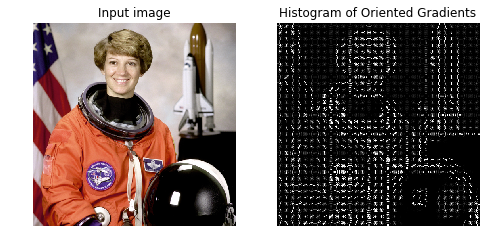

In [0]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from numpy import linspace, pi, asarray


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

(32, 32, 1, 1, 8)
(32, 32, 8)


Text(0.5, 1.0, 'Histogram of major gradients')

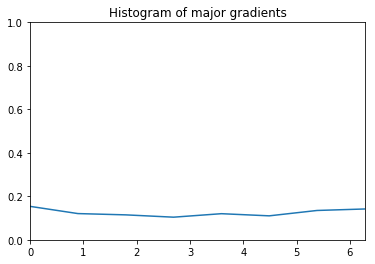

In [0]:
# now lets look at the over-all gradient statistics
print(fd.shape)
fd2=fd.squeeze()
print(fd2.shape)
grad_stats=asarray([fd2[:,:,x].sum() for x in range(fd2.shape[2])])
grad_stats=grad_stats/grad_stats.sum()

plt.plot(linspace(0,2*pi,8), grad_stats, label='data')
plt.xlim(0, 2*pi)
plt.ylim(0, 1)
plt.title('Histogram of major gradients')


### GLCM Texture Features


This example illustrates texture classification using grey level
co-occurrence matrices (GLCMs). A GLCM is a histogram of co-occurring
greyscale values at a given offset over an image.

In this example, samples of two different textures are extracted from
an image: grassy areas and sky areas. For each patch, a GLCM with
a horizontal offset of 5 is computed. Next, two features of the
GLCM matrices are computed: dissimilarity and correlation. These are
plotted to illustrate that the classes form clusters in feature space.

In a typical classification problem, the final step (not included in
this example) would be to train a classifier, such as logistic
regression, to label image patches from new images.




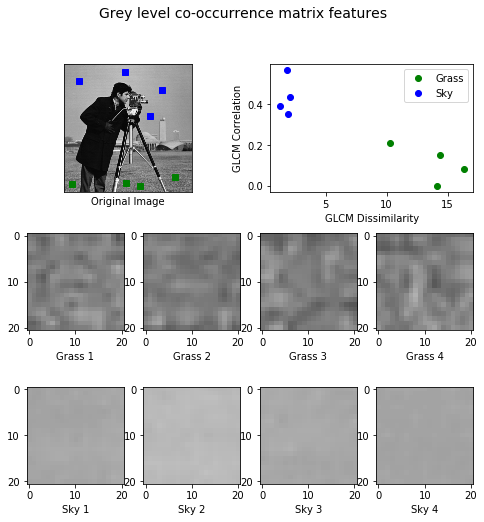

In [0]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data


PATCH_SIZE = 21

# open the camera image
image = data.camera()

# select some patches from grassy areas of the image
grass_locations = [(474, 291), (440, 433), (466, 18), (462, 236)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
sky_locations = [(54, 48), (21, 233), (90, 380), (195, 330)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax = fig.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()

## Measuring properties of parts of an image

What if the image is not the data we care about, but rather we want to measure objects *inside* the image? Here are some easy ways to measure the object in our images after performing the steps necessary to identify those objects. 

[Measure geometrical properties of regions in a segmented image](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html#sphx-glr-auto-examples-segmentation-plot-regionprops-py)

[Create a network of links and nodes out of an image by using measures of proximity and similarity](https://vcansimplify.wordpress.com/2014/07/06/scikit-image-rag-introduction/)

[Advanced ways to skeletonize an image (and presumably measure things)](https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html#sphx-glr-auto-examples-edges-plot-skeleton-py)

[Identify lines in an image and get line parameters (helpful to apply after skeletonization)](https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html#sphx-glr-auto-examples-edges-plot-line-hough-transform-py)

[Identify circles and ellipses in an image and get their parameters](https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html#sphx-glr-auto-examples-edges-plot-circular-elliptical-hough-transform-py)

[Identify contours (lines of constant values) in images and other arrays](https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py)

[Approximate and subdivite already identified polygons](https://scikit-image.org/docs/dev/auto_examples/edges/plot_polygon.html#sphx-glr-auto-examples-edges-plot-polygon-py)


### Measure region properties


This example shows how to measure properties of labelled image regions.




/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


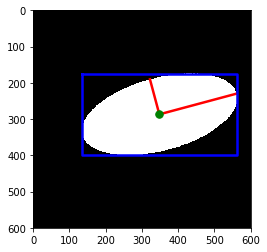

In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import ellipse
from skimage.measure import label, regionprops
from skimage.transform import rotate


image = np.zeros((600, 600))

rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1

image = rotate(image, angle=15, order=0)

label_img = label(image)
regions = regionprops(label_img)

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

In [0]:
region1=regions[0]

In [0]:
region1.